In [57]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import time
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.utils import resample

from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

In [58]:
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [59]:
data = pd.read_csv('data/modified_utc_dataset.csv')

# Initial data exploration
print(data.head())

   Duration Protocol Direction State  Source_Type_of_Service  \
0  1.026539      tcp        ->  S_RA                     0.0   
1  1.009595      tcp        ->  S_RA                     0.0   
2  3.056586      tcp        ->  SR_A                     0.0   
3  3.111769      tcp        ->  SR_A                     0.0   
4  3.083411      tcp        ->  SR_A                     0.0   

   Destination_Type_of_Service  Total_Packets  Total_Bytes  Source_Bytes  \
0                          0.0              4          276           156   
1                          0.0              4          276           156   
2                          0.0              3          182           122   
3                          0.0              3          182           122   
4                          0.0              3          182           122   

                                    Label  
0  flow=Background-Established-cmpgw-CVUT  
1  flow=Background-Established-cmpgw-CVUT  
2             flow=Backgro

In [60]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

**Feature selection**
- we have seen the correlation between 'Total_Packets' and 'Total_Bytes' is approximately one.
- The 'label's purpose is to help us identify whether the observation is from a botnet or not.

In [61]:
columns_to_drop = ['Label', 'Total_Bytes']
columns_to_drop = [col for col in columns_to_drop if col in data.columns]

data['botnet'] = data['Label'].apply(lambda x: 1 if 'flow=From-Botnet' in x else 0)

data = data.drop(columns_to_drop, axis =1)

In [62]:
# Encoding categorical features into numerical
data['Protocol'] = data['Protocol'].astype('category').cat.codes
data['Protocol'] = data['Protocol'].astype(np.int32)
data['Direction'] = data['Direction'].astype('category').cat.codes
data['Direction'] = data['Direction'].astype(np.int32)
data['State'] = data['State'].astype('category').cat.codes
data['State'] = data['State'].astype(np.int32)

## Class Imbalance

The dataset exhibits a significant class imbalance between two classes:

- **'not-botnet' (0)**: 1,587,187 instances
- **'botnet' (1)**: 33,986 instances

This class distribution indicates a severe imbalance, where the majority class ('not-botnet') heavily outweighs the minority class ('botnet').

To address this issue, we downsampled the majority class ('not-botnet') to match the number of instances in the minority class ('botnet'). This was done using the `RandomUnderSampler` from the `imbalanced-learn` library.

### Resampling Data and Applying Cross-Validation

We applied the resampling technique to balance the dataset and then performed cross-validation on various models to evaluate their performance.

In [63]:
class_1_count = data[data['botnet'] == 1].shape[0]
class_0_downsampled = resample(data[data['botnet'] == 0],
                               replace=False,    # sample without replacement
                               n_samples=class_1_count, # number of samples
                               random_state=42) # reproducible results

# Combine the downsampled minority class with the original majority class
df_resampled = pd.concat([data[data['botnet'] == 1], class_0_downsampled])

## Feature importance
**Some features doesn't even have a single observation representing the other class**

In [64]:
X = df_resampled.drop('botnet', axis =1)
y = df_resampled['botnet']

In [65]:
# Check for zero variance features and remove them
variance = X.var()
zero_variance_features = variance[variance == 0].index
if len(zero_variance_features) > 0:
    X.drop(columns=zero_variance_features, inplace=True)


In [66]:
# Apply chi-squared test and create a dictionary that holds the p-value and the features.
chi_scores, p_values = chi2(X, y)
chi2_results = {feature: p_value for feature, p_value in zip(X.columns, p_values)}

print(chi2_results)

{'Duration': 0.0, 'Protocol': 1.1582758894439864e-30, 'Direction': 0.0, 'State': 0.0, 'Source_Type_of_Service': 1.4367211464103852e-21, 'Destination_Type_of_Service': 9.635090009780229e-05, 'Total_Packets': 0.0, 'Source_Bytes': 0.0}


In [67]:
# Normalize the feature data (if necessary for the specific context)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [69]:
y_resampled_series = pd.Series(y_train)
print(y_resampled_series.value_counts())

botnet
0    21881
1    21872
Name: count, dtype: int64


In [70]:
X_train.shape

(43753, 8)

Training LogisticRegression...
testing LogisticRegression finished.
LogisticRegression Performance:
Time Taken: 0.94 seconds
Accuracy: 0.7518968827132279
Precision: 0.6869918699186992
Recall: 0.9261965655827549
F1-Score: 0.7888594989886417
ROC-AUC: 0.7517533605589896
              precision    recall  f1-score   support

           0       0.89      0.58      0.70      5465
           1       0.69      0.93      0.79      5474

    accuracy                           0.75     10939
   macro avg       0.79      0.75      0.74     10939
weighted avg       0.79      0.75      0.74     10939



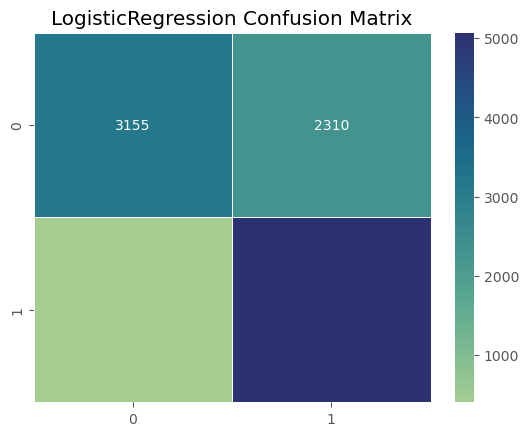

Training DecisionTree...
testing DecisionTree finished.
DecisionTree Performance:
Time Taken: 1.63 seconds
Accuracy: 0.8959685528841759
Precision: 0.8822284908321579
Recall: 0.9141395688710267
F1-Score: 0.8979005921406783
ROC-AUC: 0.8959535904739397
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      5465
           1       0.88      0.91      0.90      5474

    accuracy                           0.90     10939
   macro avg       0.90      0.90      0.90     10939
weighted avg       0.90      0.90      0.90     10939



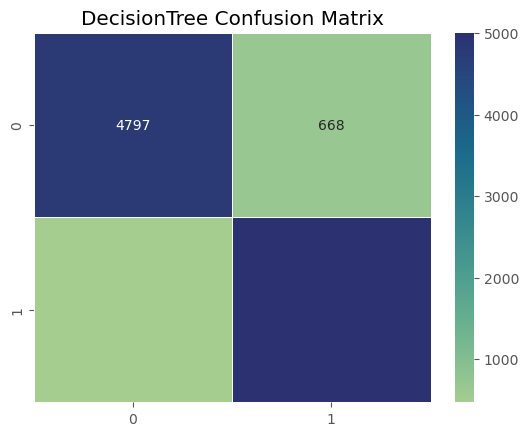

Training RandomForest...
testing RandomForest finished.
RandomForest Performance:
Time Taken: 51.99 seconds
Accuracy: 0.9057500685620258
Precision: 0.9039825422804146
Recall: 0.9081110705151626
F1-Score: 0.906042103344573
ROC-AUC: 0.9057481244616068
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      5465
           1       0.90      0.91      0.91      5474

    accuracy                           0.91     10939
   macro avg       0.91      0.91      0.91     10939
weighted avg       0.91      0.91      0.91     10939



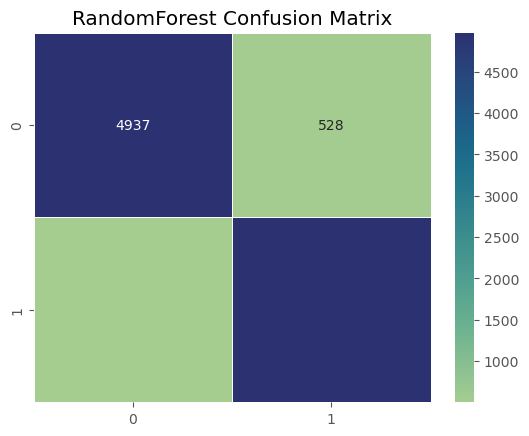

Training XGBoost...
testing XGBoost finished.
XGBoost Performance:
Time Taken: 18.49 seconds
Accuracy: 0.9161714964804827
Precision: 0.9005097556688346
Recall: 0.9358786993058092
F1-Score: 0.9178536235778912
ROC-AUC: 0.9161552691405533
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      5465
           1       0.90      0.94      0.92      5474

    accuracy                           0.92     10939
   macro avg       0.92      0.92      0.92     10939
weighted avg       0.92      0.92      0.92     10939



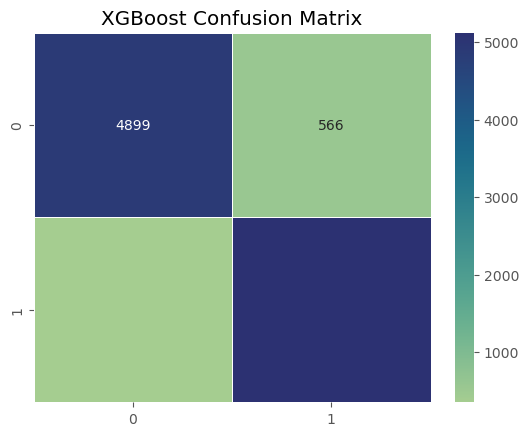

Training SVC...
testing SVC finished.
SVC Performance:
Time Taken: 709.80 seconds
Accuracy: 0.7586616692567877
Precision: 0.6940564228978362
Recall: 0.9258312020460358
F1-Score: 0.7933625547902317
ROC-AUC: 0.7585240182233838
              precision    recall  f1-score   support

           0       0.89      0.59      0.71      5465
           1       0.69      0.93      0.79      5474

    accuracy                           0.76     10939
   macro avg       0.79      0.76      0.75     10939
weighted avg       0.79      0.76      0.75     10939



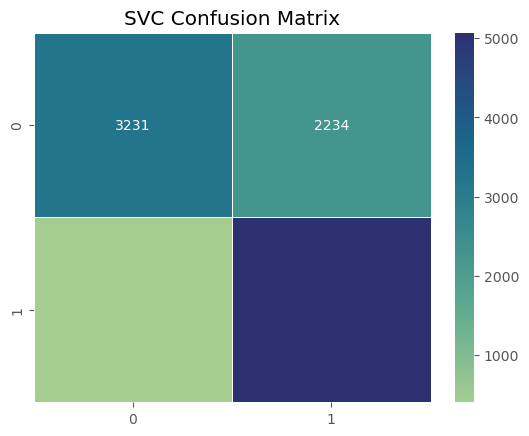

Training KNN...
testing KNN finished.
KNN Performance:
Time Taken: 36.50 seconds
Accuracy: 0.9064813968370052
Precision: 0.894802199751641
Recall: 0.9214468396054074
F1-Score: 0.9079290792907929
ROC-AUC: 0.9064690739655582
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      5465
           1       0.89      0.92      0.91      5474

    accuracy                           0.91     10939
   macro avg       0.91      0.91      0.91     10939
weighted avg       0.91      0.91      0.91     10939



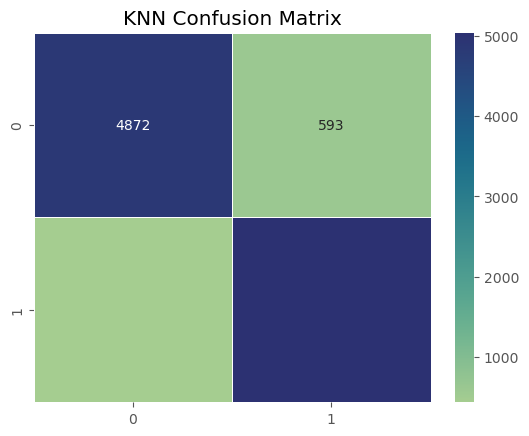

In [72]:
# Define models and hyperparameters for GridSearchCV
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVC': SVC(),
    'KNN': KNeighborsClassifier()

}

params = {
    'LogisticRegression': {'C': [0.1, 1, 10], 'penalty': ['l2']},
    'DecisionTree': {'max_depth': [None, 10, 20, 30]},
    'RandomForest': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]},
    'XGBoost': {'n_estimators': [10, 50, 100], 'max_depth': [3, 6, 9], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf']},
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
}

# Dictionary to store model performance metrics
model_metrics = {
    'Model': [],
    'Time Taken': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Hyperparameter tuning and model evaluation
for model_name, model in models.items():
    print(f"Training {model_name}...")

    start_time = time.time()
    grid = GridSearchCV(model, params[model_name], cv=5, scoring='roc_auc')
    grid.fit(X_train, y_train)
    end_time = time.time()

    best_model = grid.best_estimator_

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    time_taken = end_time - start_time
    print(f"testing {model_name} finished.")

    # Store metrics in the dictionary
    model_metrics['Model'].append(model_name)
    model_metrics['Time Taken'].append(time_taken)
    model_metrics['Accuracy'].append(accuracy)
    model_metrics['Precision'].append(precision)
    model_metrics['Recall'].append(recall)
    model_metrics['F1-Score'].append(f1)

    print(f"{model_name} Performance:")
    print(f"Time Taken: {time_taken:.2f} seconds")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap = 'crest', fmt='d', linewidth=.5)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Save the best model for each classifier.
    joblib.dump(best_model, f'{model_name}_best_model.pkl')

metrics_df = pd.DataFrame(model_metrics)


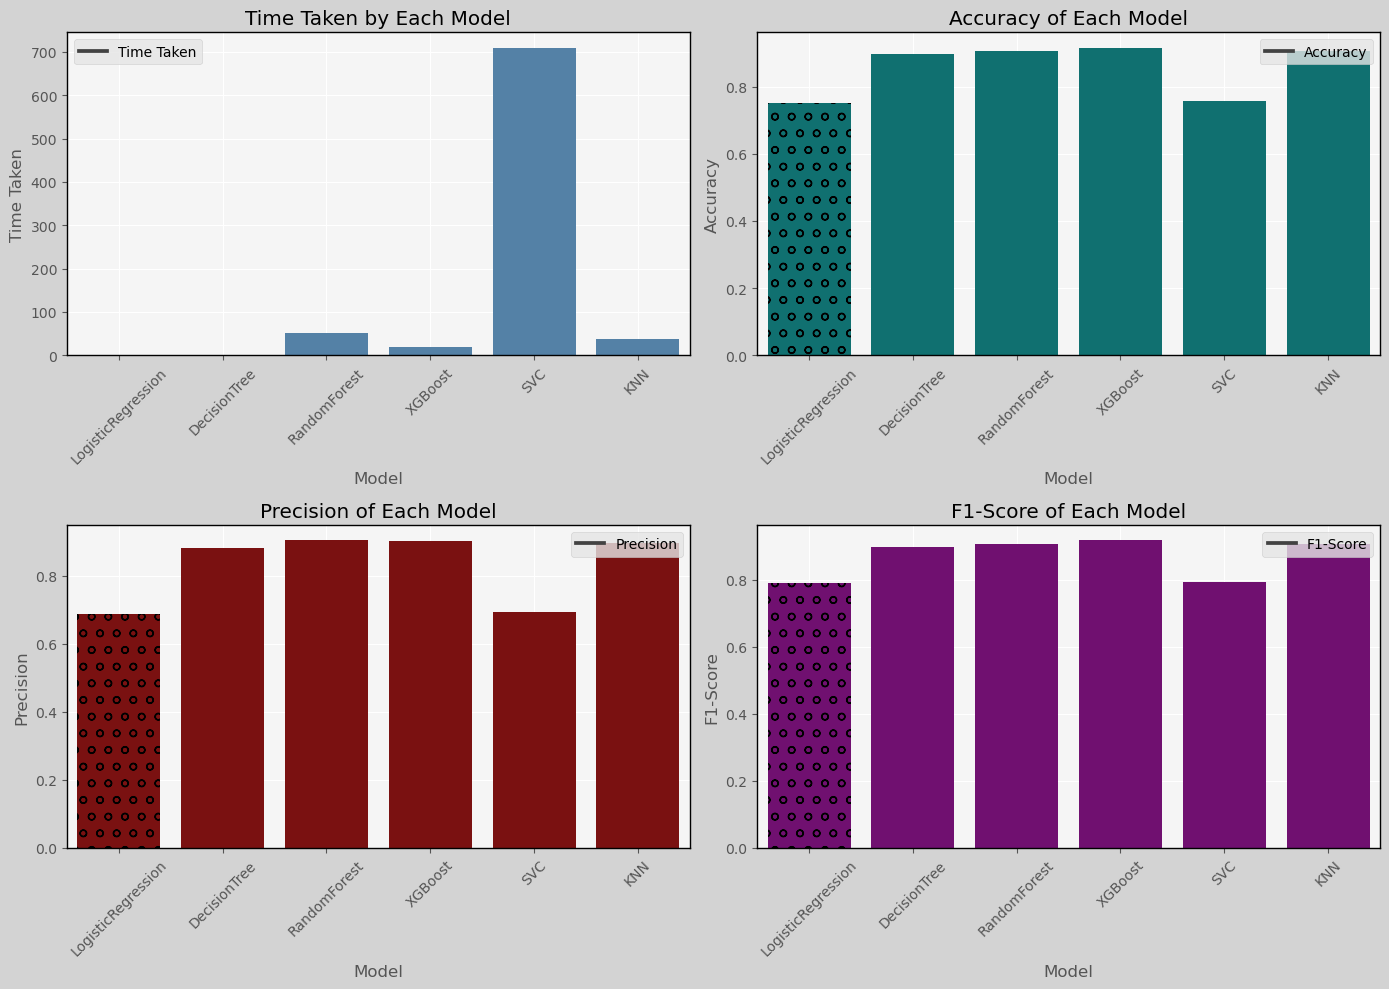

In [73]:
plt.style.use('ggplot')
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h']

# Plotting the metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

fig.patch.set_facecolor('lightgrey')

# Time Taken by Each Model
sns.barplot(x='Model', y='Time Taken', data=metrics_df, ax=axes[0, 0], color='steelblue')
for i, bar in enumerate(axes[0, 0].patches):
    bar.set_hatch(markers[i % len(markers)])
axes[0, 0].set_title('Time Taken by Each Model')
axes[0, 0].legend(['Time Taken'])
axes[0, 0].grid(True)

# Accuracy of Each Model
sns.barplot(x='Model', y='Accuracy', data=metrics_df, ax=axes[0, 1], color='teal')
for i, bar in enumerate(axes[0, 1].patches):
    bar.set_hatch(markers[i % len(markers)])
axes[0, 1].set_title('Accuracy of Each Model')
axes[0, 1].legend(['Accuracy'])
axes[0, 1].grid(True)

# Precision of Each Model
sns.barplot(x='Model', y='Precision', data=metrics_df, ax=axes[1, 0], color='darkred')
for i, bar in enumerate(axes[1, 0].patches):
    bar.set_hatch(markers[i % len(markers)])
axes[1, 0].set_title('Precision of Each Model')
axes[1, 0].legend(['Precision'])
axes[1, 0].grid(True)

# F1-Score of Each Model
sns.barplot(x='Model', y='F1-Score', data=metrics_df, ax=axes[1, 1], color='purple')
for i, bar in enumerate(axes[1, 1].patches):
    bar.set_hatch(markers[i % len(markers)])
axes[1, 1].set_title('F1-Score of Each Model')
axes[1, 1].legend(['F1-Score'])
axes[1, 1].grid(True)

for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.set_facecolor('whitesmoke')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')

plt.tight_layout()
plt.show()
